In [87]:
import preprocessor as p
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


In [88]:


data = pd.read_excel('data/r1_r2_annotations_liwc_h.xlsx')

def preprocess_text(text):
    # Remove mentions
    # text = re.sub(r'@\w+', '', text)
    # Convert to lowercase
    text = text.lower()
    return text
data = data[data['majority_vote'] != "NoMajority"]
data.reset_index(drop=True, inplace=True)

data['proc_text'] = data['proc_text'].apply(preprocess_text)
print(data[['text', 'proc_text']].head())

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit and transform the processed text
tfidf_matrix = vectorizer.fit_transform(data['proc_text'])

# Normalize the TF-IDF features
tfidf_normalized = normalize(tfidf_matrix, norm='l1', axis=1)

print('TF-IDF feature matrix shape:', tfidf_normalized.shape)

                                                text  \
0  Fuck you china. I was 2 years clear of severe ...   
1  Feeling so off today and I can’t tell if this ...   
2  Good lord people we need to stop having people...   
3  I'm telling yall, Chill the fuck out!! This Vi...   
4  Episode of #CoronaVirus panic. Man took his gl...   

                                           proc_text  
0  fuck you china. i was 2 years clear of severe ...  
1  feeling so off today and i can’t tell if this ...  
2  good lord people we need to stop having people...  
3  i'm telling yall, chill the fuck out!! this vi...  
4  episode of #coronavirus panic. man took his gl...  
TF-IDF feature matrix shape: (353, 1000)


In [89]:
X_train_tweet, X_test_tweet, y_train, y_test = train_test_split(tfidf_normalized, data['majority_vote'], test_size=0.2, random_state=42)
display(X_train_tweet[:2],X_test_tweet[:2])

<2x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 26 stored elements in Compressed Sparse Row format>

<2x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 22 stored elements in Compressed Sparse Row format>

In [90]:
def do_logistic_regression(X_tr,X_te):
    # Setting up the logistic regression model
    logreg = LogisticRegression(solver='liblinear', multi_class='auto')

    # Defining the parameter grid for grid search
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }

    # Performing grid search with 5-fold cross-validation
    grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_tr, y_train)

    # Best parameters found by grid search
    best_params = grid_search.best_params_
    print('Best parameters found by grid search:', best_params)

    # Training the model with the best parameters
    best_model = grid_search.best_estimator_

    # Predicting on both training and testing sets
    y_pred_train = best_model.predict(X_tr)
    y_pred_test = best_model.predict(X_te)

    return y_pred_train,y_pred_test
        

In [91]:
labels = y_train.unique()

def plot_confustion_matrix(labels_test, labels_pred,title=''):
    acc = np.mean(labels_test == labels_pred)
    cm = confusion_matrix(y_true=labels_test, y_pred=labels_pred)
    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='03d', cmap='coolwarm')
    plt.xlabel('Prediction', fontsize = 12) 
    plt.xticks(rotation=45)
    plt.ylabel('Truth', fontsize = 12) 
    plt.title(f"Confusion Matrix testing: {title} (acc={round(acc*100,4)}%)", fontsize = 15)
    return cm

def evaluate(y_pred_test):
    class_report = classification_report(y_test, y_pred_test)
    print('Classification Report:\n', class_report)

    cm = plot_confustion_matrix(y_test, y_pred_test)

Best parameters found by grid search: {'C': 100, 'penalty': 'l1'}
Classification Report:
               precision    recall  f1-score   support

          PO       0.84      0.78      0.81        27
          PP       0.88      0.81      0.84        26
          UN       0.82      1.00      0.90        18

    accuracy                           0.85        71
   macro avg       0.84      0.86      0.85        71
weighted avg       0.85      0.85      0.84        71



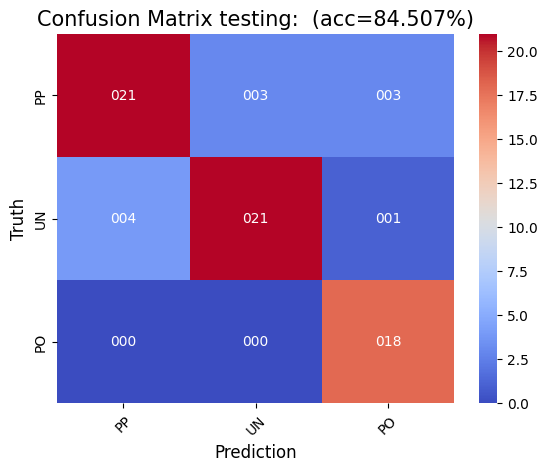

In [92]:
# print("Using TF-IDF")
# print("tf-idf shape: ", X_train_tweet_tfid.shape)
# X_train_full = np.concatenate((X_train,X_train_tweet.toarray()),axis=1)
# X_test_full = np.concatenate((X_test,X_test_tweet.toarray()),axis=1)
# print("full shape: ",X_train_full.shape)

y_pred_tr, y_pred_te = do_logistic_regression(X_train_tweet,X_test_tweet)
evaluate(y_pred_te)
